In [1]:
# Importing the required libraries
import numpy as np
import torch as tc
import matplotlib.pyplot as plt
import torch.nn.functional as nnf
from torchvision import transforms 
from torchvision.io import read_image
from PIL import Image
import random
import math
import sys
%matplotlib inline

C:\Users\hari4\anaconda3\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


### Question1

In [2]:
# Function to apply convolution on a feature map with a single kernel
def conv_function(image, kernel, stride, padding, act_func):
    height = image.shape[0]
    width = image.shape[1]
    depth = image.shape[2]
    
    k_height = kernel.shape[0]
    k_width = kernel.shape[1]
    k_depth = kernel.shape[2]
    if(stride == 0) :
        return "Please enter positive stride."
    if(depth != k_depth or height + 2*padding < k_height or width + 2*padding < kernel.shape[1]):
        return "Wrong dimensions of image/kernel."
    
    new_image = tc.zeros((height+2*padding, width+2*padding, depth))
    for i in range(height) :
        for j in range(width):
            for k in range(depth) :
                new_image[padding + i][padding + j][k] = image[i][j][k]
                
    new_height = math.floor((height - k_height + 2*padding) / stride) + 1
    new_width = math.floor((width - k_width + 2*padding) / stride) + 1
    conv_image = tc.zeros((new_height, new_width))
    i = 0
    j = 0
    while i < new_height:
        j = 0 
        while j < new_width:
            temp = new_image[i*stride:i*stride+k_height,j*stride:j*stride+k_width] * kernel
            conv_sum = tc.sum(temp)
            if(act_func == "sigmoid"):
                conv_image[i][j] = tc.sigmoid(conv_sum)
            elif(act_func == "tanh"):
                conv_image[i][j] = tc.tanh(conv_sum)
            elif(act_func == "relu"):
                conv_image[i][j] = nnf.relu(conv_sum)
            elif(act_func == "lrelu"):
                conv_image[i][j] = nnf.leaky_relu(conv_sum)
            else:
                return "Enter valid acitvation function."
             
            j += 1
        i += 1
    return conv_image

        
    
    

In [3]:
tc.manual_seed(50)
image = tc.rand(size=(4, 4, 2))
kernel = tc.rand(size=(2, 2, 2))

conv_image = conv_function(image, kernel, 2, 0 , "tanh")

In [4]:
image

tensor([[[0.6180, 0.0687],
         [0.3893, 0.0404],
         [0.4013, 0.1442],
         [0.4605, 0.4877]],

        [[0.5927, 0.9634],
         [0.1230, 0.4048],
         [0.4985, 0.9987],
         [0.6049, 0.5229]],

        [[0.6974, 0.2505],
         [0.3624, 0.4621],
         [0.7145, 0.5058],
         [0.0518, 0.2492]],

        [[0.2395, 0.4233],
         [0.0022, 0.6848],
         [0.7497, 0.2489],
         [0.3490, 0.1953]]])

In [5]:
kernel

tensor([[[0.2792, 0.2526],
         [0.3792, 0.7686]],

        [[0.6907, 0.7526],
         [0.1184, 0.8699]]])

In [6]:
conv_image

tensor([[0.9536, 0.9809],
        [0.9499, 0.8966]])

In [7]:
img = Image.open("image1.jpg")

convert_tensor = transforms.ToTensor()
logo = convert_tensor(img)

In [8]:
logo.shape

torch.Size([3, 294, 300])

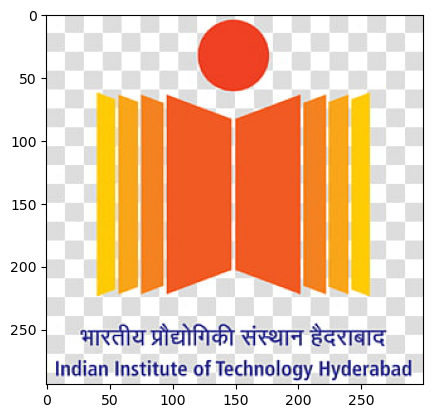

In [9]:
plt.imshow(logo.permute(1, 2, 0))

In [10]:
# Kernels to extract vertical and horizontal edges from image
k_vertical_edge = tc.tensor([[-1, -4, -1],
                                        [0, 0, 0],
                                        [1, 4, 1]], dtype=tc.float32)
k_horizontal_edge = tc.tensor([[-1, 0, 1],
                                        [-2, 0, 2],
                                        [-1, 0, 1]], dtype=tc.float32)
kernel_x = tc.stack([k_horizontal_edge] * 3).permute(2, 1, 0)
kernel_y = tc.stack([k_vertical_edge] * 3)
horizontal_edges = conv_function(image=logo.permute(1, 2, 0), kernel=kernel_x, stride=1, padding=0, act_func="relu")
vertical_edges = conv_function(image=logo.permute(1, 2, 0), kernel=kernel_y, stride=1, padding=0, act_func="relu")
image_edges = tc.sqrt(horizontal_edges**2 + vertical_edges**2)

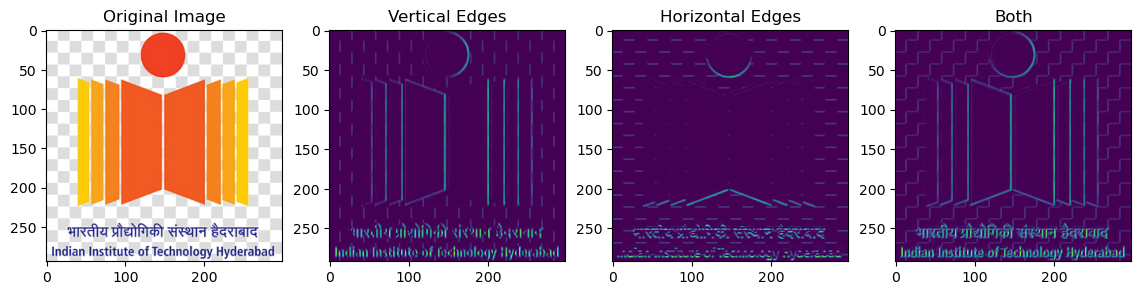

In [11]:
plt.figure(figsize=(14, 4))
plt.subplot(1, 4, 1)
plt.imshow(logo.permute(1, 2, 0))
plt.title('Original Image')

plt.subplot(1, 4, 2)
plt.imshow(vertical_edges.squeeze().numpy())
plt.title('Vertical Edges')

plt.subplot(1, 4, 3)
plt.imshow(horizontal_edges.squeeze().numpy())
plt.title('Horizontal Edges')

plt.subplot(1, 4, 4)
plt.imshow(image_edges.squeeze().numpy())
plt.title('Both')
plt.subplots_adjust(wspace=0.2)

In [12]:
image_edges.shape

torch.Size([292, 298])

### Question 2


In [15]:
# Pooling image given strise, has option to perform Global Average pooling
def pooling(conv_image, pool_func, stride=1, GAP=False):
    m = conv_image.shape[0]
    n = conv_image.shape[1]
    if GAP:
        p = 1
        q = 1
        
        stride1 = m
        stride2 = n
    else:    
        p = math.floor(m/stride)
        q = math.floor(n/stride)
        stride1 = stride
        stride2 = stride
    
    
    output = tc.zeros(p, q)
    i = 0
    j = 0
    while i < p:
        j = 0
        while j < q:
            if pool_func == "max":
                output[i][j] = tc.max(conv_image[i*stride1:(i+1)*stride1, j*stride2:(j+1)*stride2])
            elif pool_func == "min":
                output[i][j] = tc.min(conv_image[i*stride1:(i+1)*stride1, j*stride2:(j+1)*stride2])
            elif pool_func == "avg":
                output[i][j] = tc.mean(conv_image[i*stride1:(i+1)*stride1, j*stride2:(j+1)*stride2])
            else:
                return "Choose appropriate pooling function."
            j += 1
        i += 1
    
    return output
            
    

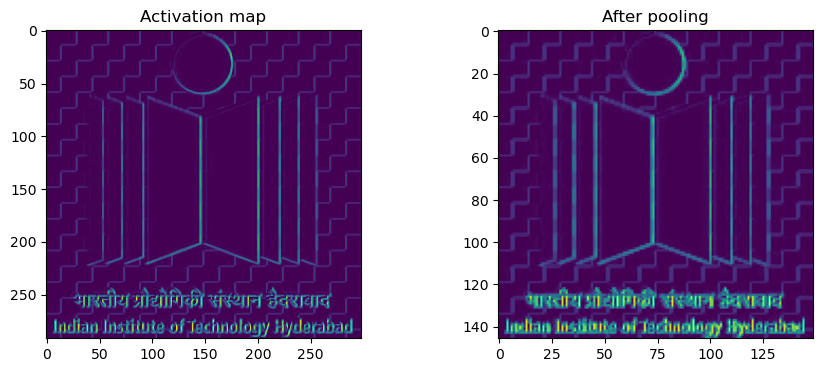

In [16]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(image_edges.squeeze().numpy())
plt.title('Activation map')

plt.subplot(1, 2, 2)
plt.imshow(pooling(image_edges, "max", 2).squeeze().numpy())
plt.title('After pooling')
plt.subplots_adjust(wspace=0.4)

### Question 3

In [17]:
# Function to convolve input immage volume with multiple kernels
def conv_layer_func(input_volume, kernels, stride, padding, act_func):
    height = input_volume.shape[0]
    width = input_volume.shape[1]
    channels = input_volume.shape[2]
    
    k_height = kernels.shape[0]
    k_width = kernels.shape[1]
    k_channels = kernels.shape[2]
    num_kernels = kernels.shape[3]
    
    if channels != k_channels:
        return "Wrong dimensions for kernel/image."
    
    output = tc.unsqueeze(conv_function(input_volume, kernels[:, :, :, 0], padding=0, stride=1, act_func=act_func), dim=-1)
    for i in range(1, num_kernels):
        act_map = conv_function(input_volume, kernels[:, :, :, i], padding=0, stride=1, act_func=act_func)
        output = tc.cat((output, act_map.unsqueeze(-1)), dim=-1)
        
    
    return output

In [18]:
# Using kernels to extract horizontal and vertical edges at once, along with dummy kernel of ones
kernel_edges = tc.cat((kernel_x.unsqueeze(-1), kernel_y.unsqueeze(-1)), dim=-1)
kernel_edges = tc.cat((kernel_edges, tc.ones(3, 3, 3, 1)), dim=-1)
kernel_edges.shape

torch.Size([3, 3, 3, 3])

In [19]:
output = conv_layer_func(logo.permute(1, 2, 0), kernel_edges, 1, 0, "relu")

In [20]:
output.shape

torch.Size([292, 298, 3])

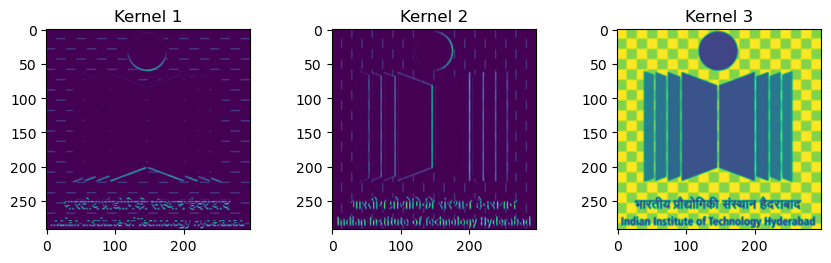

In [21]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 3, 1)
plt.imshow(output[:, :, 0])
plt.title('Kernel 1')

plt.subplot(1, 3, 2)
plt.imshow(output[:, :, 1])
plt.title('Kernel 2')

plt.subplot(1, 3, 3)
plt.imshow(output[:, :, 2])
plt.title('Kernel 3')
plt.subplots_adjust(wspace=0.4)

### Question 4

In [22]:
# Function to perform pooling on input image volume
def pool_layer_func(input_volume, pool_func="avg", stride=1, GAP=False):
    height = input_volume.shape[0]
    width = input_volume.shape[1]
    channels = input_volume.shape[2]
    if GAP:
        output = []
        for i in range(channels):
            output.append(pooling(input_volume[:,:,i], pool_func="avg", GAP=True).item())
        return tc.tensor(output)
    
    
    output = tc.unsqueeze(pooling(input_volume[:, :, 0], stride=stride, pool_func=pool_func), dim=-1)
    for i in range(1, channels):
        temp_pool = pooling(input_volume[:,:, i], stride=stride, pool_func=pool_func)
        output = tc.cat((output, temp_pool.unsqueeze(-1)), dim=-1)
    return output

In [23]:
pool_layer_func(logo.permute(1, 2, 0), GAP=True)

tensor([0.9177, 0.7457, 0.6232])

In [24]:
output = pool_layer_func(logo.permute(1, 2, 0), pool_func='max', stride = 2)

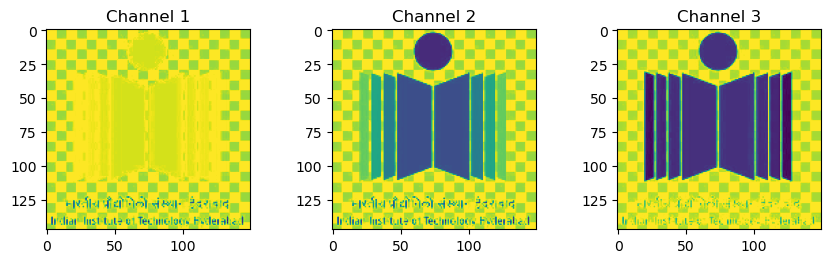

In [25]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 3, 1)
plt.imshow(output[:, :, 0])
plt.title('Channel 1')

plt.subplot(1, 3, 2)
plt.imshow(output[:, :, 1])
plt.title('Channel 2')

plt.subplot(1, 3, 3)
plt.imshow(output[:, :, 2])
plt.title('Channel 3')
plt.subplots_adjust(wspace=0.4)

### Question 5

In [26]:
def MLP(input_vec, num_hidden, layer_sizes, act_func, op_size):
    W = []
    b = []
    n = input_vec.shape[0]
    if num_hidden != layer_sizes.shape[0]:
        return "Incorrect number of hidden layers."
    W.append(tc.rand((n, layer_sizes[0])))
    b.append(tc.rand(layer_sizes[0], 1))
    
    for i in range(1, num_hidden):
        W.append(tc.rand((layer_sizes[i-1], layer_sizes[i])))
        b.append(tc.rand(layer_sizes[i], 1))
    W.append(tc.rand((layer_sizes[num_hidden-1], op_size)))
    b.append(tc.rand(op_size, 1))
    
    output = input_vec.unsqueeze(-1).float()
    for i in range(num_hidden + 1):
        
        temp = tc.transpose(W[i], 0, 1)
#         print(tc.matmul(temp, output).shape)
#         print(b[i].shape)
        w_sum = tc.matmul(temp, output) + b[i]
#         print(w_sum.shape)
        if(act_func == "relu"):
            output = nnf.relu(w_sum)
        elif(act_func == "sigmoid"):
            output = tc.sigmoid(w_sum)
        elif(act_func == "lrelu"):
            output = nnf.leaky_relu(w_sum)
        elif(act_func == "tanh"):
            output = tc.tanh(w_sum)
        else:
            return "Wrong activation function."

    softmax_output = nnf.softmax(output, dim=0)
    
    return output, softmax_output

    
        
    

In [27]:
tc.manual_seed(50)
MLP(tc.tensor([1,2,3]), 3, tc.tensor([1, 2, 3]), "relu", 3)

(tensor([[2.3287],
         [2.7407],
         [2.3106]]),
 tensor([[0.2864],
         [0.4324],
         [0.2812]]))

### Question 6

In [28]:
def CNN(input_volume, kernels, kernel_nums, pool_sizes, op_size, hidden_lay_size):
    m = kernel_nums[0]
    output = conv_layer_func(input_volume, tc.stack(kernels[:m], dim=3), stride=1, padding=0, act_func="relu")
    output = pool_layer_func(output, "max", pool_sizes[0])
    output = conv_layer_func(output, tc.stack(kernels[m:], dim=3), stride=1, padding=0, act_func="sigmoid")
    output = pool_layer_func(output, "max", pool_sizes[1])
    output = pool_layer_func(output, GAP=True)
    output, softmax_output = MLP(output.reshape(-1), 1, layer_sizes=tc.tensor([100]), act_func="relu", op_size=op_size)
    return output, softmax_output

In [29]:
image = Image.open("question6.jpg.JPEG")

input_image = convert_tensor(image)

In [30]:
input_image = input_image.permute(1, 2, 0)
input_image.shape


torch.Size([224, 224, 3])

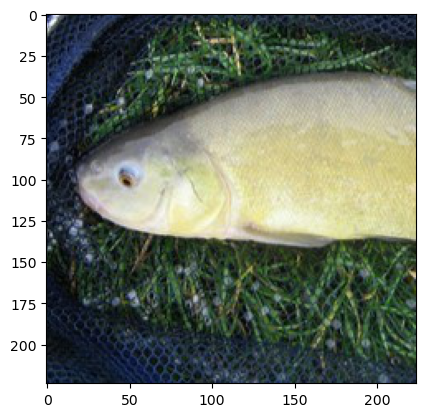

In [31]:
plt.imshow(input_image)

In [32]:
kernels = []
for i in range(16):
    kernels.append(tc.rand((5, 5, 3)))

for i in range(32):
    kernels.append(tc.rand((3, 3, 16)))
pool_sizes = [2, 2]
act_funcs = ["relu", "sigmoid"]
kernel_nums = [16, 32]
output, softmax_output = CNN(input_image, kernels, kernel_nums, pool_sizes, 1000, 10)

In [33]:
output.shape

torch.Size([1000, 1])

In [34]:
MLP(tc.rand(32), 1, layer_sizes=tc.tensor([100]), act_func="relu", op_size=1000)[0].shape

torch.Size([1000, 1])

### Question 7

In [35]:
def make_dataset(dataset_len):
    sequence_lens = tc.randint(2, 11, (dataset_len,))
    dataset = []
    labels = []
#     print(sequence_lens)
    for i in range(dataset_len):
        data = []
        m = 1/sequence_lens[i]
        count = 0
        label = 0
        for j in range(sequence_lens[i]):
            x = tc.rand(1).item()
            if(count == 2):
                data.append([x, 0])
            elif sequence_lens[i] - j == 2 and count == 0:
                data.append([x, 1])
                count += 1
                label += x
            elif sequence_lens[i] - j == 1 and count == 1:
                data.append([x, 1])
                label += x
            elif x < m:
                data.append([x, 1])
                count += 1
                label += x
                
            else:
                data.append([tc.rand(1).item(), 0])
            
        dataset.append(tc.tensor(data))
        labels.append(label)
    return dataset, labels

In [36]:
tc.manual_seed(70)
data, labels = make_dataset(5000)

In [37]:
data[0]

tensor([[0.0966, 1.0000],
        [0.1533, 0.0000],
        [0.9739, 0.0000],
        [0.0782, 0.0000],
        [0.4695, 0.0000],
        [0.2906, 0.0000],
        [0.1226, 1.0000],
        [0.5209, 0.0000]])

In [39]:
class Elmon_RNN:
    def __init__(self, hidden_dim, input_dim, output_dim, learning_rate=0.005):
        low = -1 / np.sqrt(hidden_dim)
        high = low * -1
        self.Whh = (high - low) * tc.rand((hidden_dim, hidden_dim), requires_grad = True) + low
        self.Whh.retain_grad()
        self.Why = (high - low) * tc.rand((hidden_dim, output_dim), requires_grad = True) + low
        self.Why.retain_grad()
        self.bh = (high - low) * tc.rand(hidden_dim, requires_grad = True) + low
        self.bh.retain_grad()
        self.hidden_state = tc.zeros(hidden_dim, requires_grad = True)
        self.hidden_state.retain_grad()
        low = -1 / np.sqrt(output_dim)
        high = low * -1
        self.by = (high - low) * tc.rand(output_dim, requires_grad = True) + low
        self.by.retain_grad()
        low = -1 / np.sqrt(input_dim)
        high = low * -1
        self.Wxh = (high - low) * tc.rand((input_dim, hidden_dim), requires_grad = True) + low
        self.Wxh.retain_grad()
        self.learning_rate = learning_rate
        
    def forward_pass(self, input_x, true_value):
        for ele in input_x:
            self.hidden_state = nnf.relu(self.Wxh.T @ ele + self.Whh.T @ self.hidden_state + self.bh)
            
        output = nnf.relu(self.Why.T @ self.hidden_state + self.by)
        loss = (true_value - output).pow(2)
        return loss
    
    def SGD(self, input_x, true_value):
        for ele in input_x:
            self.hidden_state = nnf.relu(self.Wxh.T @ ele + self.Whh.T @ self.hidden_state + self.bh)
            
        output = nnf.relu(self.Why.T @ self.hidden_state + self.by)
        loss = (true_value - output).pow(2)
        loss.backward(retain_graph=True)
        with tc.no_grad():
            self.Whh -= self.learning_rate * self.Whh.grad
            self.Wxh -= self.learning_rate * self.Wxh.grad
            self.Why -= self.learning_rate * self.Why.grad
            self.bh -= self.learning_rate * self.bh.grad
            self.by -= self.learning_rate * self.by.grad

        self.Wxh.grad.zero_()
        self.Whh.grad.zero_()
        self.Why.grad.zero_()
        self.bh.grad.zero_()
        self.by.grad.zero_()
        
        return loss

        
    def reset_hidden_state(self):
        self.hidden_state = tc.zeros(self.hidden_state.shape[0], requires_grad=True)




In [40]:
tc.manual_seed(50)
E_RNN = Elmon_RNN(2, 2, 1, 0.0001)
E_RNN_loss = []

for i in range(70):
    Loss = 0
    for j in range(len(data)):
        Loss += E_RNN.SGD(data[j], labels[j])
        E_RNN.reset_hidden_state()
    print(f"Loss at epoch {i} : {Loss.item()}")
    E_RNN_loss.append(Loss)


Loss at epoch 0 : 1831.128662109375
Loss at epoch 1 : 1192.427490234375
Loss at epoch 2 : 1111.459228515625
Loss at epoch 3 : 1099.604736328125
Loss at epoch 4 : 1096.50146484375
Loss at epoch 5 : 1094.10498046875
Loss at epoch 6 : 1091.040771484375
Loss at epoch 7 : 1086.682861328125
Loss at epoch 8 : 1080.3587646484375
Loss at epoch 9 : 1071.280029296875
Loss at epoch 10 : 1058.6331787109375
Loss at epoch 11 : 1041.9658203125
Loss at epoch 12 : 1021.4100341796875
Loss at epoch 13 : 997.3060302734375
Loss at epoch 14 : 969.9164428710938
Loss at epoch 15 : 939.0579833984375
Loss at epoch 16 : 904.2933349609375
Loss at epoch 17 : 865.250244140625
Loss at epoch 18 : 821.8939208984375
Loss at epoch 19 : 774.6221313476562
Loss at epoch 20 : 724.0142211914062
Loss at epoch 21 : 670.8817749023438
Loss at epoch 22 : 616.2106323242188
Loss at epoch 23 : 561.13525390625
Loss at epoch 24 : 506.7578430175781
Loss at epoch 25 : 454.19915771484375
Loss at epoch 26 : 404.4348449707031
Loss at epoch 

In [44]:
class LSTM:
    def __init__(self, hidden_dim, input_dim, output_dim, learning_rate=0.005):
        low = -1 / np.sqrt(hidden_dim)
        high = low * -1
        
        self.Wfh = (high - low) * tc.rand((hidden_dim, hidden_dim), requires_grad = True) + low
        self.Wfh.retain_grad()
        self.Wih = (high - low) * tc.rand((hidden_dim, hidden_dim), requires_grad = True) + low
        self.Wih.retain_grad()
        self.Woh = (high - low) * tc.rand((hidden_dim, hidden_dim), requires_grad = True) + low
        self.Woh.retain_grad()
        
        self.Wch = (high - low) * tc.rand((hidden_dim, hidden_dim), requires_grad = True) + low
        self.Wch.retain_grad()
        
        self.bo = (high - low) * tc.rand(hidden_dim, requires_grad = True) + low
        self.bo.retain_grad()
        self.bi = (high - low) * tc.rand(hidden_dim, requires_grad = True) + low
        self.bi.retain_grad()
        self.bf = (high - low) * tc.rand(hidden_dim, requires_grad = True) + low
        self.bf.retain_grad()
        
        self.bc = (high - low) * tc.rand(hidden_dim, requires_grad = True) + low
        self.bc.retain_grad()
        
        self.hidden_state = tc.zeros(hidden_dim, requires_grad = True)
        self.hidden_state.retain_grad()
        
        self.cell_state = tc.zeros(hidden_dim, requires_grad = True)
        self.cell_state.retain_grad()
        
        low = -1 / np.sqrt(input_dim)
        high = low * -1
        self.Ufx = (high - low) * tc.rand((input_dim, hidden_dim), requires_grad = True) + low
        self.Ufx.retain_grad()
        self.Uix = (high - low) * tc.rand((input_dim, hidden_dim), requires_grad = True) + low
        self.Uix.retain_grad()
        self.Uox = (high - low) * tc.rand((input_dim, hidden_dim), requires_grad = True) + low
        self.Uox.retain_grad()
        
        self.Ucx = (high - low) * tc.rand((input_dim, hidden_dim), requires_grad = True) + low
        self.Ucx.retain_grad()
        
        self.learning_rate = learning_rate
        
    def forward_pass(self, input_x, true_value):
        for ele in input_x:
            self.input_gate = tc.sigmoid(self.Uix.T @ ele + self.Wih.T @ self.hidden_state + self.bi)
            self.forget_gate = tc.sigmoid(self.Ufx.T @ ele + self.Wfh.T @ self.hidden_state + self.bf)
            read_state = tc.tanh(self.Ucx.T @ ele + self.Wch.T @ self.hidden_state + self.bc)
            self.cell_state = self.forget_gate * self.cell_state + self.input_gate * read_state
            self.output_gate = tc.sigmoid(self.Uox.T @ ele + self.Woh.T @ self.hidden_state + self.bo)
            self.hidden_state = self.output_gate * tc.tanh(self.cell_state)
            
        output = tc.sum(self.hidden_state)
        loss = (true_value - output).pow(2)
        return loss
    def SGD(self, input_x, true_value):
        for ele in input_x:
            self.input_gate = tc.sigmoid(self.Uix.T @ ele + self.Wih.T @ self.hidden_state + self.bi)
            self.forget_gate = tc.sigmoid(self.Ufx.T @ ele + self.Wfh.T @ self.hidden_state + self.bf)
            read_state = tc.tanh(self.Ucx.T @ ele + self.Wch.T @ self.hidden_state + self.bc)
            self.cell_state = self.forget_gate * self.cell_state + self.input_gate * read_state
            self.output_gate = tc.sigmoid(self.Uox.T @ ele + self.Woh.T @ self.hidden_state + self.bo)
            self.hidden_state = self.output_gate * tc.tanh(self.cell_state)
            
        output = tc.sum(self.hidden_state)
        loss = (true_value - output).pow(2)
        loss.backward(retain_graph=True)
        with tc.no_grad():
            self.Woh -= self.learning_rate * self.Woh.grad
            self.Uox -= self.learning_rate * self.Uox.grad
            self.Wih -= self.learning_rate * self.Wih.grad
            self.Uix -= self.learning_rate * self.Uix.grad
            self.Wfh -= self.learning_rate * self.Wfh.grad
            self.Ufx -= self.learning_rate * self.Ufx.grad
            self.Wch -= self.learning_rate * self.Wch.grad
            self.Ucx -= self.learning_rate * self.Ucx.grad
            self.bo -= self.learning_rate * self.bo.grad
            self.bi -= self.learning_rate * self.bi.grad
            self.bf -= self.learning_rate * self.bf.grad
            self.bc -= self.learning_rate * self.bc.grad

        self.Woh.grad.zero_()
        self.Uox.grad.zero_()
        self.Wih.grad.zero_()
        self.Uix.grad.zero_()
        self.Wfh.grad.zero_()
        self.Ufx.grad.zero_()
        self.Wch.grad.zero_()
        self.Ucx.grad.zero_()
        self.bo.grad.zero_()
        self.bi.grad.zero_()
        self.bf.grad.zero_() 
        self.bc.grad.zero_() 

        
        return loss

        
    def reset_hidden_states(self):
        self.cell_state = tc.zeros(self.cell_state.shape[0], requires_grad=True)
        self.hidden_state = tc.zeros(self.hidden_state.shape[0], requires_grad=True)



In [45]:
tc.manual_seed(50)
lstm = LSTM(4, 2, 1, 0.005)
LSTM_loss = []
for i in range(20):
    Loss = 0
    for j in range(len(data)):
        Loss += lstm.SGD(data[j], labels[j])
        lstm.reset_hidden_states()
    print(f"Loss at epoch {i} : {Loss.item()}")
    LSTM_loss.append(Loss)

Loss at epoch 0 : 390.4826354980469
Loss at epoch 1 : 158.53468322753906
Loss at epoch 2 : 119.32568359375
Loss at epoch 3 : 89.38510131835938
Loss at epoch 4 : 65.25062561035156
Loss at epoch 5 : 47.31415939331055
Loss at epoch 6 : 35.33646774291992
Loss at epoch 7 : 27.821107864379883
Loss at epoch 8 : 22.988059997558594
Loss at epoch 9 : 19.632781982421875
Loss at epoch 10 : 17.135181427001953
Loss at epoch 11 : 15.19339370727539
Loss at epoch 12 : 13.646166801452637
Loss at epoch 13 : 12.393878936767578
Loss at epoch 14 : 11.367677688598633
Loss at epoch 15 : 10.51677417755127
Loss at epoch 16 : 9.802639961242676
Loss at epoch 17 : 9.195694923400879
Loss at epoch 18 : 8.673364639282227
Loss at epoch 19 : 8.218367576599121


tensor([[0.0966, 1.0000],
        [0.1533, 0.0000],
        [0.9739, 0.0000],
        [0.0782, 0.0000],
        [0.4695, 0.0000],
        [0.2906, 0.0000],
        [0.1226, 1.0000],
        [0.5209, 0.0000]])

In [41]:
class GRU:
    def __init__(self, hidden_dim, input_dim, output_dim, learning_rate=0.005):
        low = -1 / np.sqrt(hidden_dim)
        high = low * -1
        
        self.Wzh = (high - low) * tc.rand((hidden_dim, hidden_dim), requires_grad = True) + low
        self.Wzh.retain_grad()
        self.Wrh = (high - low) * tc.rand((hidden_dim, hidden_dim), requires_grad = True) + low
        self.Wrh.retain_grad()
        self.Whh = (high - low) * tc.rand((hidden_dim, hidden_dim), requires_grad = True) + low
        self.Whh.retain_grad()
        
        self.hidden_state = tc.zeros(hidden_dim, requires_grad = True)
        self.hidden_state.retain_grad()


        low = -1 / np.sqrt(input_dim)
        high = low * -1
        self.Uzx = (high - low) * tc.rand((input_dim, hidden_dim), requires_grad = True) + low
        self.Uzx.retain_grad()
        self.Urx = (high - low) * tc.rand((input_dim, hidden_dim), requires_grad = True) + low
        self.Urx.retain_grad()
        self.Uhx = (high - low) * tc.rand((input_dim, hidden_dim), requires_grad = True) + low
        self.Uhx.retain_grad()
        
        self.learning_rate = learning_rate
        
    def forward_pass(self, input_x, true_value):
        for ele in input_x:
            update_gate = tc.sigmoid(self.Uzx.T @ ele + self.Wzh.T @ self.hidden_state)
            output_gate = tc.sigmoid(self.Urx.T @ ele + self.Wrh.T @ self.hidden_state)
            output_state = tc.tanh(self.Uhx.T @ ele + self.Whh.T @ (self.hidden_state * output_gate))
            self.hidden_state = (1 - update_gate) * self.hidden_state + update_gate * output_state
            
        output = tc.sum(self.hidden_state)
        loss = (true_value - output).pow(2)
        return loss
    def SGD(self, input_x, true_value):
        for ele in input_x:
            update_gate = tc.sigmoid(self.Uzx.T @ ele + self.Wzh.T @ self.hidden_state)
            output_gate = tc.sigmoid(self.Urx.T @ ele + self.Wrh.T @ self.hidden_state)
            output_state = tc.tanh(self.Uhx.T @ ele + self.Whh.T @ (self.hidden_state * output_gate))
            self.hidden_state = (1 - update_gate) * self.hidden_state + update_gate * output_state
            
        output = tc.sum(self.hidden_state)
        loss = (true_value - output).pow(2)
        loss.backward(retain_graph=True)
        with tc.no_grad():
            self.Wzh -= self.learning_rate * self.Wzh.grad
            self.Uzx -= self.learning_rate * self.Uzx.grad
            self.Wrh -= self.learning_rate * self.Wrh.grad
            self.Urx -= self.learning_rate * self.Urx.grad
            self.Whh -= self.learning_rate * self.Whh.grad
            self.Uhx -= self.learning_rate * self.Uhx.grad


        self.Wzh.grad.zero_()
        self.Uzx.grad.zero_()
        self.Wrh.grad.zero_()
        self.Urx.grad.zero_()
        self.Whh.grad.zero_()
        self.Uhx.grad.zero_()
        

        
        return loss

        
    def reset_hidden_states(self):
        self.hidden_state = tc.zeros(self.hidden_state.shape[0], requires_grad=True)



In [42]:
tc.manual_seed(40)
gru = GRU(4, 2, 1, 0.005)
GRU_Loss = []
for i in range(20):
    Loss = 0
    for j in range(len(data)):
        Loss += gru.SGD(data[j], labels[j])
        gru.reset_hidden_states()
    print(f"Loss at epoch {i} : {Loss.item()}")

Loss at epoch 0 : 337.8255310058594
Loss at epoch 1 : 139.91854858398438
Loss at epoch 2 : 72.04048919677734
Loss at epoch 3 : 48.29197692871094
Loss at epoch 4 : 35.691280364990234
Loss at epoch 5 : 28.114398956298828
Loss at epoch 6 : 23.269859313964844
Loss at epoch 7 : 19.958072662353516
Loss at epoch 8 : 17.55034828186035
Loss at epoch 9 : 15.712301254272461
Loss at epoch 10 : 14.256484031677246
Loss at epoch 11 : 13.070694923400879
Loss at epoch 12 : 12.083189010620117
Loss at epoch 13 : 11.245416641235352
Loss at epoch 14 : 10.5231351852417
Loss at epoch 15 : 9.891355514526367
Loss at epoch 16 : 9.331521034240723
Loss at epoch 17 : 8.829612731933594
Loss at epoch 18 : 8.374971389770508
Loss at epoch 19 : 7.959527015686035


In [79]:
tc.manual_seed(38)
test_data, labels = make_dataset(1000)
GRU_Loss = 0
LSTM_Loss = 0
ELMON_Loss = 0
gru.reset_hidden_states()
lstm.reset_hidden_states()
Baseline_loss = 0
E_RNN.reset_hidden_state()
for j in range(1000):
    GRU_Loss += gru.forward_pass(test_data[j], labels[j]).item()
    LSTM_Loss += lstm.forward_pass(test_data[j], labels[j]).item()
    ELMON_Loss += E_RNN.forward_pass(test_data[j], labels[j]).item()
    Baseline_loss += (labels[j] - 1) ** 2
    gru.reset_hidden_states()
    lstm.reset_hidden_states()
    E_RNN.reset_hidden_state()
    
print(f"Baseline Loss : {Baseline_loss} ELMON loss : {ELMON_Loss} LSTM loss : {LSTM_Loss} GRU Loss : {GRU_Loss}")

Baseline Loss : 284.87170781774086 ELMON loss : 3.6914622552951784 LSTM loss : 1.8207919207491194 GRU Loss : 1.6735995962229744


#### ELMON network takes less time to train per epoch but is not able to completely capture the patterns in the data
#### LSTM takes lot of time per epoch and is able to fit the data would give higher accuracies given time to update its high number of parameters
#### GRU is the best of both worlds and provides sufficient understanding of the input with less parameters and training time